In [1]:
import urllib.request
import numpy as np
import os
import pandas as pd
import datetime as dt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [2]:
# download data
filename = os.path.join(os.getcwd(), 'Online_Retail.xlsx')
daturl = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx'
#urllib.request.urlretrieve(daturl, filename)

In [3]:
# read excel table using pandas
df = pd.read_excel(filename, sheet_name='Online Retail')

In [4]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [5]:
# drop negative quantities and unit prices
df = df[(df.Quantity >= 0) & (df.UnitPrice >= 0)]

In [6]:
# negative quantities and unit prices removed
df.sort_values('Quantity').head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
232639,557324,82600,NO SINGING METAL SIGN,1,2011-06-20 09:41:00,4.13,NaN,United Kingdom
483832,577508,21730,GLASS STAR FROSTED T-LIGHT HOLDER,1,2011-11-20 12:45:00,4.95,18127.0,United Kingdom
317674,564817,DOT,DOTCOM POSTAGE,1,2011-08-30 12:02:00,177.63,NaN,United Kingdom
317673,564817,90119,METALIC LEAVES BAG CHARMS,1,2011-08-30 12:02:00,2.46,NaN,United Kingdom
483828,577508,22557,PLASTERS IN TIN VINTAGE PAISLEY,1,2011-11-20 12:45:00,1.65,18127.0,United Kingdom


In [7]:
# helper function: build month from datetime (1st day of month)
def get_month(x): return dt.datetime(x.year, x.month, 1)

# helper function: make integers from year and month
def get_date_int(df, col):
    year = df[col].dt.year
    month = df[col].dt.month
    return year, month

In [8]:
# compute cohort month by getting each user's 1st purchase
df['InvoiceMonth'] = df['InvoiceDate'].apply(get_month)
df['CohortMonth'] = df.groupby('CustomerID')['InvoiceMonth'].transform('min')

In [9]:
# get years and months as integers
invYear, invMonth = get_date_int(df=df, col='InvoiceMonth')
cohYear, cohMonth = get_date_int(df=df, col='CohortMonth')

In [10]:
# cohort index = cohort as number of months
df['CohortIndex'] = 12*(invYear - cohYear) + (invMonth - cohMonth) + 1

In [11]:
# no. active customers from each cohort
cohort = df.groupby(['CohortMonth', 'CohortIndex'])['CustomerID'].apply(pd.Series.nunique).reset_index()
cohortCount = cohort.pivot(index='CohortMonth', columns='CohortIndex', values='CustomerID')
cohortCount.head()

CohortIndex,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0
CohortMonth,,,,,,,,,,,,,
2010-12-01,885.0,324.0,286.0,340.0,321.0,352.0,321.0,309.0,313.0,350.0,331.0,445.0,235.0
2011-01-01,417.0,92.0,111.0,96.0,134.0,120.0,103.0,101.0,125.0,136.0,152.0,49.0,NaN
2011-02-01,380.0,71.0,71.0,108.0,103.0,94.0,96.0,106.0,94.0,116.0,26.0,NaN,NaN
2011-03-01,452.0,68.0,114.0,90.0,101.0,76.0,121.0,104.0,126.0,39.0,NaN,NaN,NaN
2011-04-01,300.0,64.0,61.0,63.0,59.0,68.0,65.0,78.0,22.0,NaN,NaN,NaN,NaN


In [12]:
# compute retention rate
cohortSizes = cohortCount.iloc[:, 0]
ret = cohortCount.divide(cohortSizes, axis=0).round(3)*100

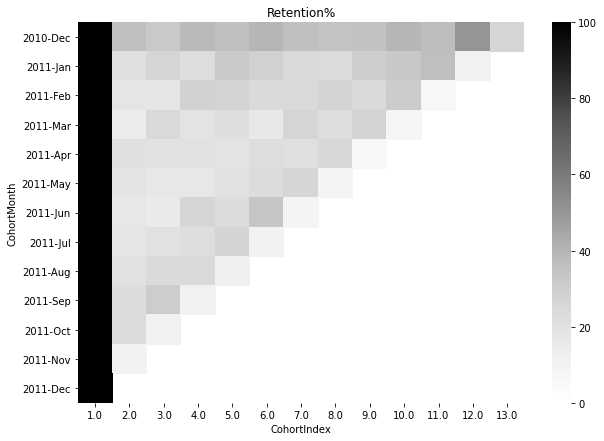

In [13]:
# heatmap
plt.figure(figsize=(10, 7))
plt.title('Retention%')
sns.heatmap(
    data=ret, vmin=0, vmax=100, cmap='Greys',
    yticklabels=ret.index.strftime('%Y-%b'),
    xticklabels=ret.columns)
plt.show()

In [14]:
# compute RFM metrics
df['TotalSum'] = df.Quantity * df.UnitPrice
snapshot = max(df['InvoiceDate']) + dt.timedelta(days=1)
RFM = df.groupby('CustomerID').agg({
        'InvoiceDate': lambda x: (snapshot - x.max()).days,
        'InvoiceNo': 'count',
        'TotalSum': 'sum'})
RFM.rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'TotalSum': 'MonetaryValue'}, inplace=True)

RFM = RFM[RFM.MonetaryValue > 0] # drop zero values
RFM.head()

,Recency,Frequency,MonetaryValue
CustomerID,,,
12346.0,326,1,77183.60
12347.0,2,182,4310.00
12348.0,75,31,1797.24
12349.0,19,73,1757.55
12350.0,310,17,334.40


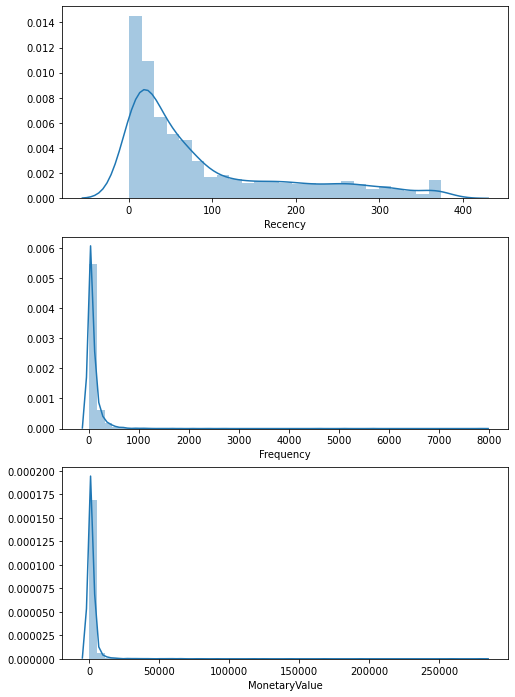

In [15]:
# check distributions of R, F and M
plt.figure(figsize=(8, 12))
plt.subplot(3, 1, 1); sns.distplot(RFM['Recency']) # recency distribution
plt.subplot(3, 1, 2); sns.distplot(RFM['Frequency']) # frequency distribution
plt.subplot(3, 1, 3); sns.distplot(RFM['MonetaryValue']) # monetary value
plt.show()

In [16]:
RFM.describe()

,Recency,Frequency,MonetaryValue
count,4338.000000,4338.000000,4338.000000
mean,92.536422,91.729599,2054.266460
std,100.014169,228.815081,8989.230441
min,1.000000,1.000000,3.750000
25%,18.000000,17.000000,307.415000
50%,51.000000,41.000000,674.485000
75%,142.000000,100.000000,1661.740000
max,374.000000,7847.000000,280206.020000


In [17]:
# log-transform and normalize
RFMlog = np.log(RFM)
scaler = StandardScaler()
scaler.fit(RFMlog)
RFMlognorm = scaler.transform(RFMlog)

In [22]:
# k-means clustering, k=3
kmeans = KMeans(n_clusters=3, random_state=2020)
kmeans.fit(RFMlognorm)
labs = kmeans.labels_

# assign resulting labels to customers
RFMk3 = RFM.assign(Cluster=labs)

# compute segment statistics
RFMk3.groupby(['Cluster']).agg({
    'Recency': ['mean', 'std'],
    'Frequency': ['mean', 'std'],
    'MonetaryValue': ['mean', 'count'],
}).round(0)

Recency        Frequency        MonetaryValue      
           mean    std      mean    std          mean count
Cluster                                                    
0          70.0   67.0      66.0   48.0        1175.0  1849
1         171.0  110.0      15.0   11.0         294.0  1524
2          13.0   13.0     262.0  438.0        6519.0   965

In [19]:
# try clustering with different values of k
sse = {}
for k in range(1, 30):
    kmeans = KMeans(n_clusters=k, random_state=2020)
    kmeans.fit(RFMlognorm)
    sse[k] = kmeans.inertia_

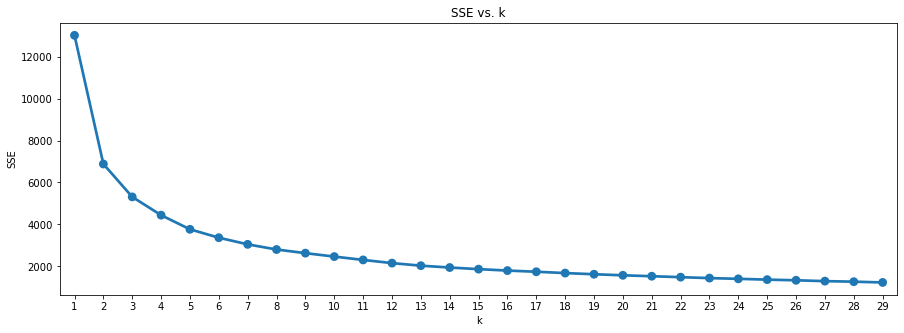

In [20]:
# plot results (SSE vs. k)
plt.figure(figsize=(15, 5))
plt.title('SSE vs. k')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()